In [1]:
# Import Necessaries
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Define data path and dataset name
data_dir = 'Dataset'
ds_name = 'Vehicles'

In [3]:
# Create Dataframe for the dataset

# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [4]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [5]:
df.head()

,filepaths,labels
0,Dataset/motorcycle/Image_21.png,motorcycle
1,Dataset/motorcycle/Image_78.jpeg,motorcycle
2,Dataset/motorcycle/Image_45.jpg,motorcycle
3,Dataset/motorcycle/Image_65.jpg,motorcycle
4,Dataset/motorcycle/Image_37.jpg,motorcycle


In [6]:
# Display Number of Examples in the dataset
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)

The Vehicles dataset has 400 images.


In [7]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The Vehicles dataset has 4 classes


In [8]:
# Display count of images in each class of the dataset
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The Vehicles dataset has: 

Class 'motorcycle' has 100 images
----------------------------------------------------------------------
Class 'Truck' has 100 images
----------------------------------------------------------------------
Class 'Car' has 100 images
----------------------------------------------------------------------
Class 'Bus' has 100 images
----------------------------------------------------------------------


In [9]:
# Split dataframe into train, valid, and test

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [10]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Vehicles dataset has 4 classes
The Validation Vehicles dataset has 4 classes
The Testing Vehicles dataset has 4 classes


In [11]:
classes_count(train_df, 'Training '+ds_name)

The Training Vehicles dataset has: 

Class 'Truck' has 82 images
----------------------------------------------------------------------
Class 'Car' has 74 images
----------------------------------------------------------------------
Class 'motorcycle' has 79 images
----------------------------------------------------------------------
Class 'Bus' has 85 images
----------------------------------------------------------------------


In [12]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Vehicles dataset has: 

Class 'motorcycle' has 11 images
----------------------------------------------------------------------
Class 'Car' has 21 images
----------------------------------------------------------------------
Class 'Truck' has 8 images
----------------------------------------------------------------------
Class 'Bus' has 8 images
----------------------------------------------------------------------


In [13]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Vehicles dataset has: 

Class 'Bus' has 7 images
----------------------------------------------------------------------
Class 'Truck' has 10 images
----------------------------------------------------------------------
Class 'motorcycle' has 10 images
----------------------------------------------------------------------
Class 'Car' has 5 images
----------------------------------------------------------------------


In [14]:
# Create Image Data Generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 320 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.


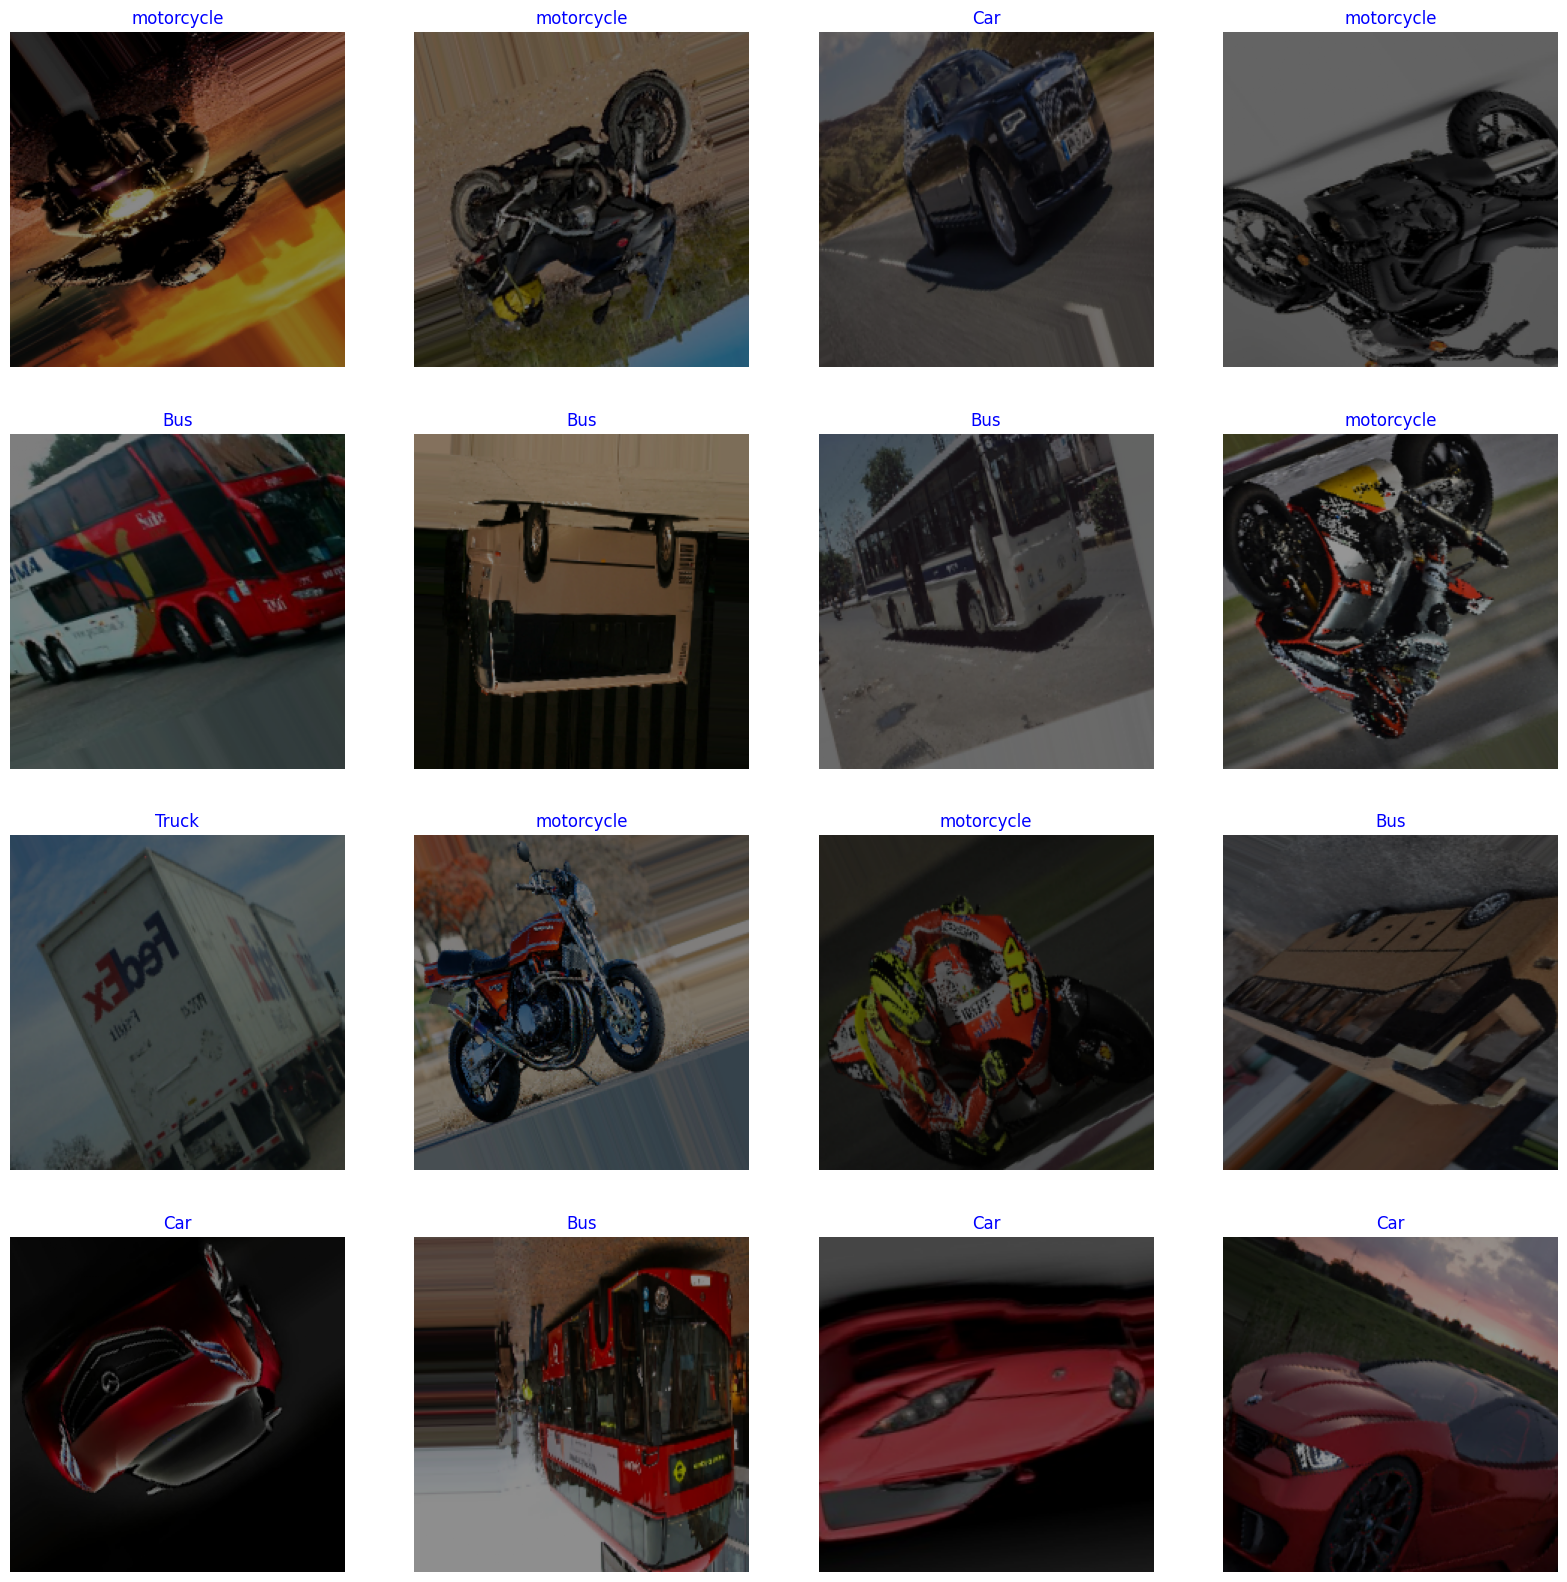

In [15]:
# Visualize Training dataset
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()

In [16]:
# Model Structure
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

2023-10-22 22:00:25.600445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 22:00:26.304041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38258 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 10,986,931
Trainable params: 200,324
Non-trainable params: 10,786,607
______________________________________

In [17]:
# Define Early Stop
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):
    
     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [ ]:
# Train Model
batch_size = 16   # set batch size for training
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/50


2023-10-22 22:00:37.891469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 1/20 [>.............................] - ETA: 3:21 - loss: 6.3703 - accuracy: 0.3750

2023-10-22 22:00:40.885557: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/20 [=======================>......] - ETA: 1s - loss: 5.1264 - accuracy: 0.6094

In [ ]:
# Evaluate Model

# Plot accuarcy and loss curve

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
# Model Accuarcy
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Get class id for y_real_class
y_true = test_gen.classes

# Get predicted class labels
y_pred = np.argmax(preds, axis=1)

# Print true and predicted class labels
print("True classes:")
print(str(test_gen.classes).replace(',', ''))
print("Predicted classes:")
print(y_pred)

# Calculate confusion matrix and classification report between y_true and y_pred
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


In [ ]:
model.save_weights('my_model_1_weights_.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('my_model_1_weights_.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ['Bus', 'Car', 'Truck', 'Motorcycle']

In [ ]:
image_path_to_test = 'Dataset/Bus/Image_10.jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = 'Dataset/Car/Image_21.jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = 'Dataset/Truck/Image_13.JPG'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = 'Dataset/motorcycle/Image_29.jpeg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
# Compare EfficientNet B0 to B7 Results
# List of EfficientNet models
effnet_models = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]
epochs = 50   # number of all epochs in training

# Loop through each model and train/evaluate
for i, effnet_model in enumerate(effnet_models):
    print(f"Training and evaluating EfficientNet B{i}...")

    base_model = effnet_model(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l=0.016), 
              activity_regularizer=tf.keras.regularizers.l1(0.006),
              bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')

    history = model.fit(x=train_gen,
                        epochs=epochs,
                        verbose=0,
                        validation_data=valid_gen,
                        validation_steps=None,
                        shuffle=False,
                        callbacks=[early_stopping])
    
    print(f"EfficientNet B{i} training completed.")

    # Evaluate the model on the test data
    test_results = model.evaluate(test_gen, verbose=0)
    print(f"Test loss for EfficientNet B{i}: {test_results[0]}")
    print(f"Test accuracy for EfficientNet B{i}: {test_results[1]}")

    # Make predictions on the test data
    y_pred = model.predict(test_gen)
    y_pred_labels = y_pred.argmax(axis=1)
    y_true_labels = test_gen.classes

    # Generate classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=train_gen.class_indices.keys())
    print(report)
    print("-"*70)
